In [9]:
import numpy as np
import copy as cp
import scipy
from scipy.sparse.linalg import spsolve
from scipy.spatial.transform import Rotation
from scipy.sparse import csr_matrix
from pyquaternion import Quaternion
import sys
import time
import matplotlib.pyplot as plt
from FUNCTIONS import inputdata
from FUNCTIONS2 import make_rig_RA_RU
from FUNCTIONS3 import *
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [11]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.zeros((npoin*nfree, npoin*nfree), dtype=np.float64)
    node_mass_array = np.zeros(npoin, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        node_mass_array[i] = node_mass
        for j in range(3):
            idx = i*nfree + j
            ret[idx,idx] = node_mass
    return ret, node_mass_array

In [12]:
# gamma: mass, omega: k
def dumping_3dfrm(gamma, omega, mass_mat, k):
    m = gamma * mass_mat
    ret = omega * k    
    for i in range(0, len(ret)):
        ret[i, i] += m[i, i]        
    return ret

In [13]:
# newmark マトリックスを作成
# newmarkのparam: alpha, beta
def newmark_3dfrm(delta_t, alpha, beta, k, mass_mat, c_mat): 
    return (1.0/beta/delta_t**2) * mass_mat  \
         + (alpha/beta/delta_t) * c_mat \
         + k

In [14]:
def assemble_3dfrm(nod, nfree, npoin, nele, node, coordsL, ae, delta_t, alpha, beta, gamma, omega, mass_mat):
    ir=np.zeros(nod*nfree, dtype=np.int)
    kL=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Local stifness matrix
    for ne in range(nele):
        i=node[0,ne]-1
        j=node[1,ne]-1
        m=node[2,ne]-1

        x1L = coordsL[0, i]
        y1L = coordsL[1, i]
        z1L = coordsL[2, i]
        x2L = coordsL[0, j]
        y2L = coordsL[1, j]
        z2L = coordsL[2, j]

        A    =ae[0,m]  # 断面積
        I11  =ae[1,m]  # y軸周り断面二次モーメント 
        I12  =ae[2,m]  # x軸周り断面二次モーメント
        I22  =ae[3,m]  # z軸周り断面二次モーメント
        J    =ae[4,m]  # ねじり定数
        E    =ae[5,m]  # ヤング率
        G    =ae[6,m]  # せん断弾性係数
        EA=E*A
        GJ=G*J
        EIy=E*I11
        EIz=E*I22
        ekL=sm_3dfrm(EA,GJ,EIy,EIz,x1L,y1L,z1L,x2L,y2L,z2L) # local element stiffness matrix                                
        ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
        ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
        # assemble
        for i in range(0, nod*nfree):
            it=ir[i]
            for j in range(0, nod*nfree):
                jt=ir[j]
                kL[it, jt] = kL[it, jt] + ekL[i,j]                                        

    c_mat=dumping_3dfrm(gamma, omega, mass_mat, kL)
    newmark_mat=newmark_3dfrm(delta_t, alpha, beta, kL, mass_mat, c_mat)
    
    return kL, c_mat, newmark_mat

In [15]:
def test_NEWMARK_FEM(kL, mass_mat, delta_t=0.001, n_t=1000):
        start=time.time()
        args = sys.argv        
        nod=2
        nfree=6
        alpha=0.5  # newmark param
        beta=0.25  # newmark param
        gamma=0.01 # dumping param
        omega=0.01 # dumping param
        npoin = kL.shape[0] // 6
        nele = npoin - 1
        npfix = 1
            
        mpfix = np.zeros((n_t+1, nfree, npoin), dtype=np.int)
        rdis = np.zeros((n_t+1, nfree, npoin), dtype=np.float64)
        for i in range(1, n_t+1):
            mpfix[i, 0, 0] = 1
            mpfix[i, 1, 0] = 1
            mpfix[i, 2, 0] = 1
            mpfix[i, 3, 0] = 1
            mpfix[i, 4, 0] = 1
            mpfix[i, 5, 0] = 1
            rdis[i, 0, 0] = 0
            rdis[i, 1, 0] = 0
            rdis[i, 2, 0] = 0
            rdis[i, 3, 0] = 0
            rdis[i, 4, 0] = 0
            rdis[i, 5, 0] = 0
        
        e_accL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_vecL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_disL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)                                
          
        c_mat=dumping_3dfrm(gamma, omega, mass_mat, kL)
        newmark_mat=newmark_3dfrm(delta_t, alpha, beta, kL, mass_mat, c_mat)
        
        for step in range(1, n_t):                                                
            fL = np.zeros((nfree*npoin), dtype=np.float64)
            if step == 1:
                fL[(npoin-1)*6+1] = -10            
            
            tmp_for_mass = (1.0/beta/delta_t**2)  * e_disL[step-1] \
                         + (1.0/beta/delta_t)     * e_vecL[step-1] \
                         + ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            tmp_for_c = (alpha/beta/delta_t)            * e_disL[step-1] \
                      + ((alpha/beta)-1.0)              * e_vecL[step-1] \
                      + delta_t * ((alpha/2/beta)-1.0)  * e_accL[step-1]                        
            
            fL = fL + np.dot(mass_mat, tmp_for_mass) + np.dot(c_mat, tmp_for_c)  
            # boudary conditions
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        fL[iz]=0.0

            for i in range (0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        newmark_mat[:,iz]=0.0
                        newmark_mat[iz,iz]=1.0
            # 疎行列圧縮格納
            sp_newmark_mat = csr_matrix(newmark_mat)
            e_disL[step] = spsolve(sp_newmark_mat, fL, use_umfpack=True)
                        
            # 拘束条件を再代入する
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        e_disL[step, iz] = rdis[step, j, i]
                        
            # 速度, 加速度計算            
            e_accL[step] = (1.0/beta/delta_t**2)  * (e_disL[step] - e_disL[step-1]) \
                            - (1.0/beta/delta_t)     * e_vecL[step-1] \
                            - ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            e_vecL[step] = (alpha/beta/delta_t)         * (e_disL[step] - e_disL[step-1]) \
                            + (1.0-(alpha/beta))           * e_vecL[step-1] \
                            + delta_t*(1.0-(alpha/2/beta)) * e_accL[step-1]
            
        dtime=time.time()-start
        print('time: {0:.3f}'.format(dtime)+'sec')
        return e_disL[:-1]

In [16]:
def format_rad2deg(rad):
    return np.rad2deg(rad + 2*np.pi) % (360)

In [17]:
def calc_phi(x, y, z):
    phi = None
    if x == 0 and y >= 0:
        phi = np.pi / 2
    elif x == 0and y < 0:
        phi = -np.pi / 2
    else:
        phi = np.arctan2(abs(y), x)
                
    phi7 = None
    if x == 0 and y == 0 and z >= 0:
        phi7 = np.pi / 2
    elif x == 0 and y == 0 and z < 0:
        phi7 = -np.pi / 2
    else:
        phi7 = np.arctan2(z, np.sqrt(x**2+(abs(y)**2)))
        
    return phi, phi7

def calc_f_from_phi(F, phi, phi7):
    FX = F[0]
    FY = F[1]
    FZ = F[2]
    fy7 = FY*np.cos(phi) - FX*np.sin(phi)
    fx7 = FY*np.sin(phi) - FX*np.cos(phi)
    
    fz7 =  FZ*np.cos(phi7) - fx7*np.sin(phi7)
    return fx7, fy7, fz7

In [18]:
def norm2(v):
    return np.sqrt(np.sum(v**2))

# v1のv2に対する正射影ベクトル
def calc_Orthographic_vector(v1, v2):
    v1dotv2 = np.dot(v1, v2)
    v2_size = norm2(v2)
    return v1dotv2/v2_size*v2

def calc_aG(rax, ray, raz, X7_nk):
    ex = np.array([1, 0, 0], dtype=np.float64)
    ey = np.array([0, 1, 0], dtype=np.float64)
    ez = np.array([0, 0, 1], dtype=np.float64)
    
    x_orth = calc_Orthographic_vector(X7_nk, ex)
    y_orth = calc_Orthographic_vector(X7_nk, ey)
    z_orth = calc_Orthographic_vector(X7_nk, ez)
    
    x_r = X7_nk - x_orth
    y_r = X7_nk - y_orth
    z_r = X7_nk - z_orth
    
    x_cross = np.cross(ex, x_r)
    y_cross = np.cross(ey, y_r)
    z_cross = np.cross(ez, z_r)
    
    aG = np.zeros((3), dtype=np.float64)
    aG += rax * norm2(x_r) / norm2(x_cross) * x_cross
    aG += ray * norm2(y_r) / norm2(y_cross) * y_cross
    aG += raz * norm2(z_r) / norm2(z_cross) * z_cross
    
    return aG[0], aG[1], aG[2]

In [19]:
def calc_local_f(F, phi, phi7):       
    fx = F[0]
    fy = F[1]
    fz = F[2]
    
    fy7 = fy*np.cos(phi) + fx*np.sin(phi)
    fx7 = fx*np.cos(phi) - fy*np.sin(phi)    
        
    fz7 =  fz*np.cos(phi7) - fx7*np.sin(phi7)
    fx77 = fz*np.sin(phi7) + fx7*np.cos(phi7)
    
    fxL = fx77
    fyL = fy7
    fzL = fz7
    return fxL, fyL, fzL

In [20]:
def calc_e_disG(dx, dy, dz, phi, phi7):
    dx7 = dx*np.cos(phi7) - dz*np.sin(phi7)
    dz7 = dx*np.sin(phi7) + dz*np.cos(phi7)
    
    Dx = dx7*np.cos(phi) + dy*np.sin(phi)
    Dy = dy*np.cos(phi) - dx7*np.sin(phi)
    Dz = dz7
    
    return Dx, Dy, Dz

In [21]:
def main_3d_NEWMARK_FEM(inp_path, alpha=0.5, beta=0.25):
    start=time.time()
    args = sys.argv   
    nod=2
    nfree=6
    npfix=1
    
    originCoordsG, ae, npoin, nele, delta_t, n_t, VX, VY, VZ, RVX, RVY, RVZ, head_mass, gamma, omega, HHT_alpha = inputdata(inp_path)    
    alpha -= HHT_alpha
    beta *= ((1-HHT_alpha)**2)
    
    mass_mat, node_mass_array=mass_3dfrm(ae[7], npoin, nfree)
    # adjust head
    node_mass_array[npoin-1] += head_mass
    for i in range((npoin-1)*6, (npoin-1)*6+3):
        mass_mat[i, i] += head_mass
    
    UX, UY, UZ, AX, AY, AZ, RAX, RAY, RAZ, qs, total_qs = make_rig_RA_RU(VX, VY, VZ, RVX, RVY, RVZ, delta_t ,originCoordsG)
    
    node = np.zeros((nod + 1, nele), dtype=np.int)
    for i in range(nele):
        node[0, i] = i+1
        node[1, i] = i+2
        node[2, i] = i+1

    # x軸平行で、グリップが原点にあり、x軸正方向へbeamが伸びていると仮定したときの座標    
    coordsL = np.zeros((3, npoin), dtype=np.float64)                    
    for i in range(npoin):
        coordsL[0, i] = np.sqrt(abs(originCoordsG[0, 0]-originCoordsG[0, i])**2 + \
                                abs(originCoordsG[1, 0]-originCoordsG[1, i])**2 + \
                                abs(originCoordsG[2, 0]-originCoordsG[2, i]**2))                
            
    # grip部分を固定      
    mpfix = np.zeros((nfree, npoin), dtype=np.int)
    rdis = np.zeros((nfree, npoin), dtype=np.float64)
    mpfix[0, 0] = 1
    mpfix[1, 0] = 1
    mpfix[2, 0] = 1
    mpfix[3, 0] = 1
    mpfix[4, 0] = 1
    mpfix[5, 0] = 1
    rdis[0, 0] = 0
    rdis[1, 0] = 0
    rdis[2, 0] = 0
    rdis[3, 0] = 0
    rdis[4, 0] = 0
    rdis[5, 0] = 0  
        
    # assembly stifness matrix & load vector
    kL, c_mat, newmark_mat = assemble_3dfrm(nod, nfree, npoin, nele, node, coordsL, ae, delta_t, alpha, beta, gamma, omega, mass_mat)

    e_accL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_vecL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_disL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)        
    e_accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
    e_disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)  
    
    accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
    disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)

    coordsG=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
    coordsG_plus_e_dis=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
    coordsG[0] = cp.deepcopy(originCoordsG)
    coordsG_plus_e_dis[0] = cp.deepcopy(originCoordsG)      
        
    
    phi, phi7 = calc_phi(originCoordsG[0, npoin-1],
                         originCoordsG[1, npoin-1],
                         originCoordsG[2, npoin-1])

    for step in range(1, n_t):            
        vx = VX[step+1, 1]
        ux = UX[step+1, 1]
        ax = AX[step+1, 1]
        vy = VY[step+1, 1]
        uy = UY[step+1, 1]
        ay = AY[step+1, 1]
        vz = VZ[step+1, 1]
        uz = UZ[step+1, 1]
        az = AZ[step+1, 1]
        
        rvx = RVX[step+1, 1]
        rax = RAX[step+1, 1]
        rvy = RVY[step+1, 1]
        ray = RAY[step+1, 1]
        rvz = RVZ[step+1, 1]
        raz = RAZ[step+1, 1]
        
        q = qs[step]
        q_prev = qs[step-1]
        q_next = qs[step+1]
        
        total_q = total_qs[step]
        
        X_n0 = originCoordsG.T[0] + np.array([ux, uy, uz], dtype=np.float64)         
        
        fL = np.zeros(npoin*nfree, dtype=np.float64)
        step_origin_x = X_n0[0]
        step_origin_y = X_n0[1]
        step_origin_z = X_n0[2]
        
        for k in range(npoin):                
            X7_0k = originCoordsG.T[k] - originCoordsG.T[0]                                    
            X7_nk = total_q.rotate(X7_0k)
            X_nk = X7_nk + X_n0
            
            coordsG[step, 0, k] = X_nk[0]
            coordsG[step, 1, k] = X_nk[1]
            coordsG[step, 2, k] = X_nk[2]
            
            node_mass = node_mass_array[k]            
                             
            raxG = 0
            rayG = 0
            razG = 0
                       
            if k > 0:
                raxG, rayG, razG = calc_aG(rax, ray, raz, X7_nk)
                                                                        
            axG = raxG + ax
            ayG = rayG + ay
            azG = razG + az     
            
            accG[step][k*6] = axG
            accG[step][k*6+1] = ayG
            accG[step][k*6+2] = azG            
                                    
            fxG = -node_mass*axG
            fyG = -node_mass*ayG
            fzG = -node_mass*azG                        
            
            F = total_q.inverse.rotate(np.array([fxG, fyG, fzG], dtype=np.float64))
            
            fLx, fLy, fLz = calc_local_f(F, phi, phi7)
            fL[k*6 + 0] = 0
            fL[k*6 + 1] = fLy
            fL[k*6 + 2] = fLz

        tmp_for_mass = (1.0/beta/delta_t**2)  * e_disL[step-1] \
                     + (1.0/beta/delta_t)     * e_vecL[step-1] \
                     + ((1.0/2/beta)-1.0)     * e_accL[step-1]

        tmp_for_c = (alpha/beta/delta_t)            * e_disL[step-1] \
                  + ((alpha/beta)-1.0)              * e_vecL[step-1] \
                  + delta_t * ((alpha/2/beta)-1.0)  * e_accL[step-1]                        

        fL += np.dot(mass_mat, tmp_for_mass) + np.dot(c_mat, tmp_for_c)  
        # boudary conditions
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:
                    iz=i*nfree+j
                    fL[iz]=0.0

        for i in range (0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:
                    iz=i*nfree+j
                    newmark_mat[:,iz]=0.0
                    newmark_mat[iz,iz]=1.0
        # 疎行列圧縮格納
        sp_newmark_mat = csr_matrix(newmark_mat)
        e_disL[step] = spsolve(sp_newmark_mat, fL, use_umfpack=True)

        # 拘束条件を再代入する
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[j, i] == 1:
                    iz=i*nfree+j
                    e_disL[step, iz] = rdis[j, i]

        # 速度, 加速度計算            
        e_accL[step] = (1.0/beta/delta_t**2)  * (e_disL[step] - e_disL[step-1]) \
                        - (1.0/beta/delta_t)     * e_vecL[step-1] \
                        - ((1.0/2/beta)-1.0)     * e_accL[step-1]

        e_vecL[step] = (alpha/beta/delta_t)         * (e_disL[step] - e_disL[step-1]) \
                        + (1.0-(alpha/beta))           * e_vecL[step-1] \
                        + delta_t*(1.0-(alpha/2/beta)) * e_accL[step-1]
        
        e_disG[step] = cp.deepcopy(e_disL[step])
        
        for i in range(npoin):
            dx = e_disL[step, i*6]
            dy = e_disL[step, i*6+1]
            dz = e_disL[step, i*6+2]            
            Dx, Dy, Dz = calc_e_disG(dx, dy, dz, phi, phi7)
            D = total_q.rotate(np.array([Dx, Dy, Dz], dtype=np.float64))
            
            ax_l = e_accL[step, i*6]
            ay_l = e_accL[step, i*6+1]
            az_l = e_accL[step, i*6+2]
            Ax, Ay, Az = calc_e_disG(ax_l, ay_l, az_l, phi, phi7)
            A = total_q.rotate(np.array([Ax, Ay, Az], dtype=np.float64))

            e_disG[step][i*6] = D[0]
            e_disG[step][i*6+1] = D[1]
            e_disG[step][i*6+2] = D[2]
            
            accG[step][i*6] += A[0]
            accG[step][i*6+1] += A[1]
            accG[step][i*6+2] += A[2]

            coordsG_plus_e_dis[step, 0, i] = coordsG[step, 0, i] + e_disG[step-1][i*6]
            coordsG_plus_e_dis[step, 1, i] = coordsG[step, 1, i] + e_disG[step-1][i*6+1]
            coordsG_plus_e_dis[step, 2, i] = coordsG[step, 2, i] + e_disG[step-1][i*6+2]                  

            disG[step][i*6  ] = coordsG_plus_e_dis[step][0][i] - originCoordsG[0][i] # dis_x
            disG[step][i*6+1] = coordsG_plus_e_dis[step][1][i] - originCoordsG[1][i] # dis_y
            disG[step][i*6+2] = coordsG_plus_e_dis[step][2][i] - originCoordsG[2][i] # dis_z                
            
            
            disG[step][i*6+3] = e_disL[step-1][i*6+3] # rux
            disG[step][i*6+4] = e_disL[step-1][i*6+4] # ruy
            disG[step][i*6+5] = e_disL[step-1][i*6+5] # ruz
            if i == 0:
                disG[step][i*6+3] += total_q.vector[0] # rux
                disG[step][i*6+4] += total_q.vector[1] # ruy
                disG[step][i*6+5] += total_q.vector[2] # ruz
        if (step % 100 == 0):
            step_time = time.time()-start
            print('{0} step: {1:.3f}'.format(step, step_time))
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return e_disL[:-1], e_disG[:-1], disG[:-1], coordsG_plus_e_dis[:-1], coordsG[:-1], kL, mass_mat, delta_t, originCoordsG, accG[:-1]

In [22]:
e_disL, e_disG, disG, coordsG_plus_dis, coordsG, kL, mass_mat, delta_t, oG, accG = \
main_3d_NEWMARK_FEM('beam-average.txt')

100 step: 1.485
200 step: 2.984
time: 3.943sec


In [23]:
e_disL2, e_disG2, disG2, coordsG_plus_dis2, coordsG2, kL2, mass_mat2, delta_t2, oG2 = \
main_3d_NEWMARK_FEM('beam-average2.txt')

100 step: 1.475
200 step: 2.894
300 step: 4.339
400 step: 5.840
500 step: 7.329
time: 7.763sec


In [25]:
e_disL3, e_disG3, disG3, coordsG_plus_dis3, coordsG3, kL3, mass_mat3, delta_t3, oG3 = \
main_3d_NEWMARK_FEM('beam-average3.txt')

100 step: 1.464
200 step: 2.888
300 step: 4.316
400 step: 5.796
500 step: 7.274
600 step: 8.763
700 step: 10.278
time: 11.756sec


In [26]:
e_disL5, e_disG5, disG5, coordsG_plus_dis5, coordsG5, kL5, mass_mat5, delta_t5, oG5 = \
main_3d_NEWMARK_FEM('beam-average5.txt')

100 step: 1.686
200 step: 3.214
300 step: 4.770
400 step: 6.322
500 step: 7.883
600 step: 9.454
700 step: 11.044
800 step: 12.596
900 step: 14.179
1000 step: 15.781
1100 step: 17.380
1200 step: 18.999
1300 step: 20.598
time: 20.992sec


In [27]:
e_disL10, e_disG10, disG10, coordsG_plus_dis10, coordsG10, kL10, mass_mat10, delta_t10, oG10 = \
main_3d_NEWMARK_FEM('beam-average10.txt')

100 step: 1.776
200 step: 3.310
300 step: 4.889
400 step: 6.441
500 step: 8.017
600 step: 9.573
700 step: 11.121
800 step: 12.700
900 step: 14.298
1000 step: 15.902
1100 step: 17.648
1200 step: 19.424
1300 step: 21.174
1400 step: 22.862
1500 step: 24.549
1600 step: 26.263
1700 step: 27.934
1800 step: 29.624
1900 step: 31.301
2000 step: 32.950
2100 step: 34.574
2200 step: 36.207
2300 step: 37.889
2400 step: 39.654
2500 step: 41.350
2600 step: 42.977
time: 43.783sec


In [28]:
abaqus_dis = get_abaqus_data('beam-averageU.txt', 265, 23)
abaqus_dis2 = get_abaqus_data('beam-average2U.txt', 530, 23)
abaqus_dis3 = get_abaqus_data('beam-average3U.txt', 795, 23)
abaqus_dis5 = get_abaqus_data('beam-average5U.txt', 1325, 23)
abaqus_dis10 = get_abaqus_data('beam-average10U.txt', 2650, 23)

In [23]:
test_dis = test_3d_NEWMARK_FEM(kL, mass_mat)
# test_dis3 = test_3d_NEWMARK_FEM(kL3, mass_mat3)

time: 0.933sec


In [24]:
calc_period_from_dis(test_dis)
# calc_period_from_dis(test_dis3)

0.215

In [25]:
calc_period_from_kL_mass_mat(kL, mass_mat)
# calc_period_from_kL_mass_mat(kL2, mass_mat2)

(0.2121486788830992+0j)

In [26]:
rigid_dis = get_rigid_dis(coordsG, oG)

In [ ]:
rigid_dis2 = get_rigid_dis(coordsG2, oG2)

In [27]:
rigid_dis3 = get_rigid_dis(coordsG3, oG3)

In [ ]:
rigid_dis5 = get_rigid_dis(coordsG5, oG5)

In [ ]:
rigid_dis10 = get_rigid_dis(coordsG10, oG10)

In [29]:
abaqus_coordsG_e_dis, coordsG_e_dis = calc_coord_e_dis(abaqus_dis, disG, coordsG)

In [30]:
abaqus_coordsG_e_dis2, coordsG_e_dis2 = calc_coord_e_dis(abaqus_dis2, disG2, coordsG2)

In [31]:
abaqus_coordsG_e_dis3, coordsG_e_dis3 = calc_coord_e_dis(abaqus_dis3, disG3, coordsG3)

In [32]:
abaqus_coordsG_e_dis5, coordsG_e_dis5 = calc_coord_e_dis(abaqus_dis5, disG5, coordsG5)

In [33]:
abaqus_coordsG_e_dis10, coordsG_e_dis10 = calc_coord_e_dis(abaqus_dis10, disG10, coordsG10)

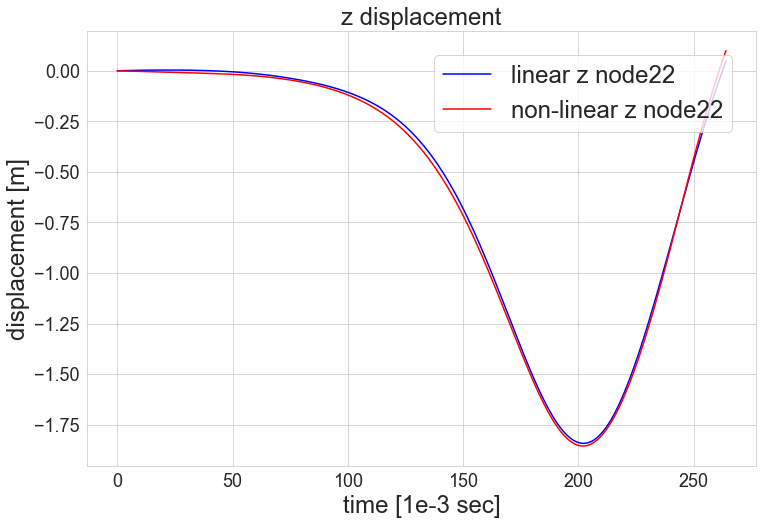

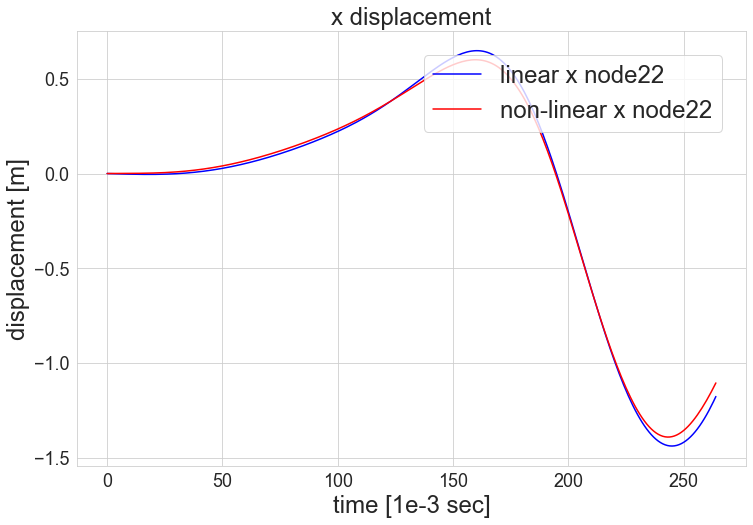

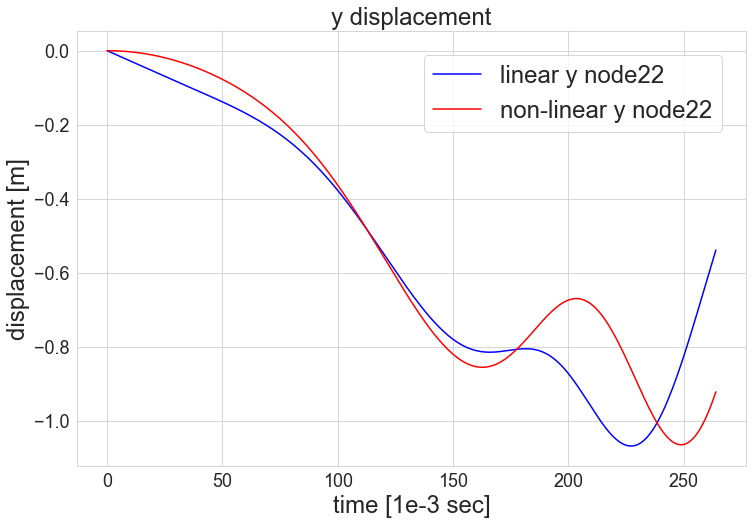

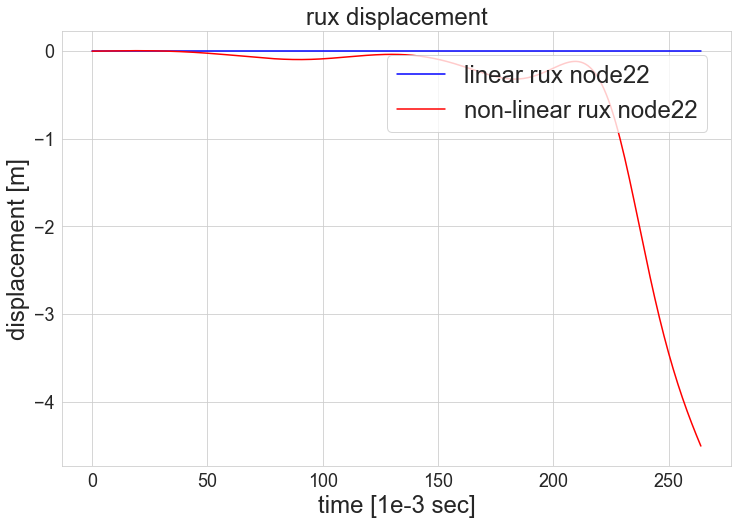

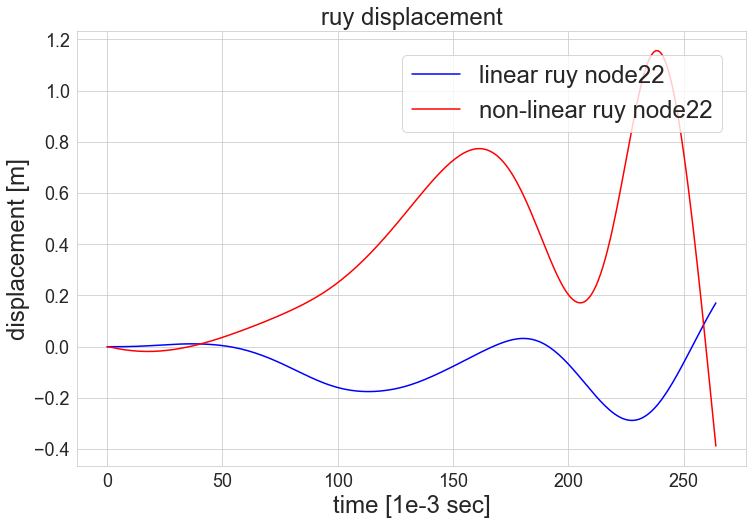

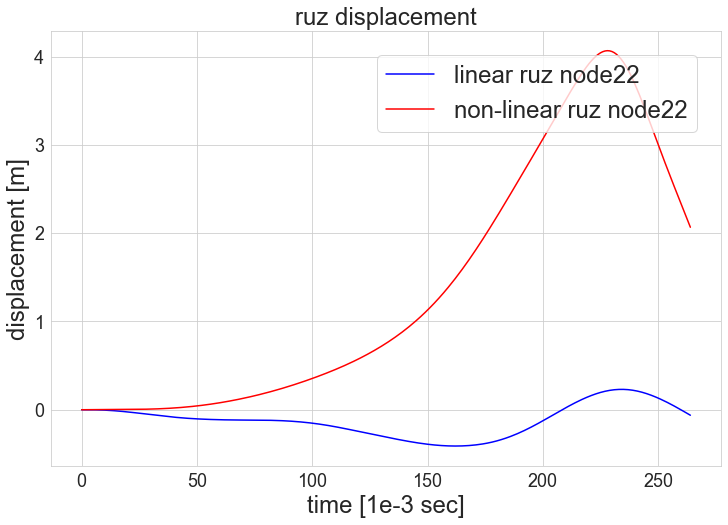

In [53]:
plot_compare_abaqus_dis(abaqus_dis, disG, [23], True, '3d-dis')

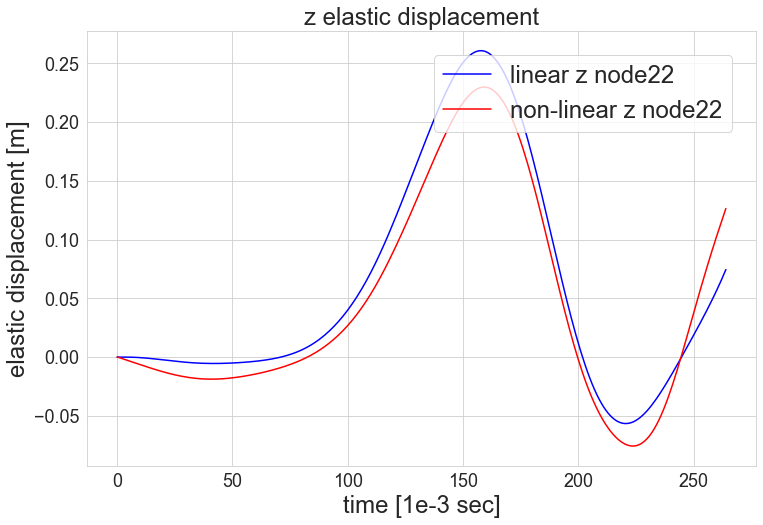

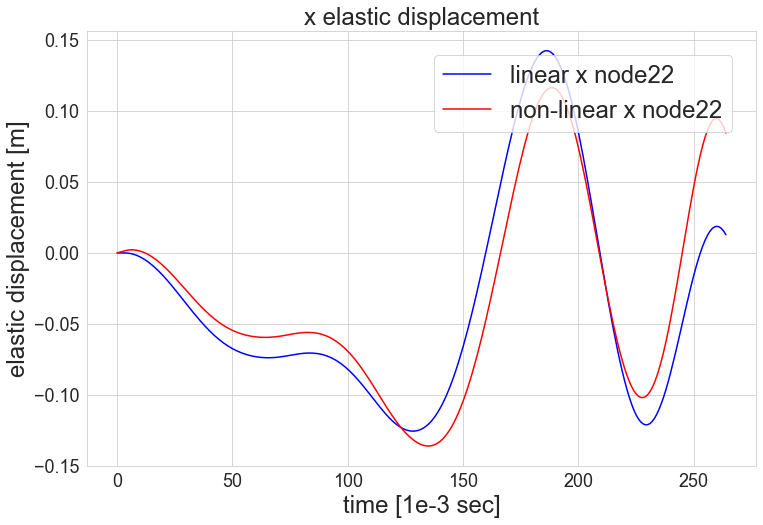

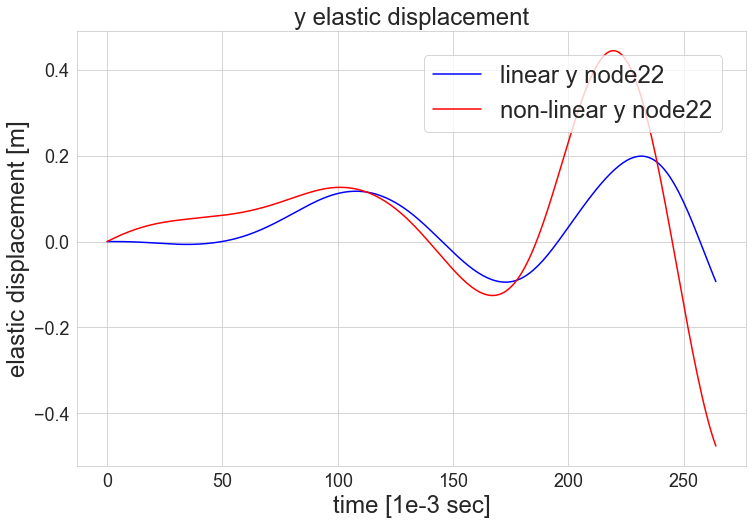

In [54]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis, coordsG_e_dis, [23], True, '3d-edis')

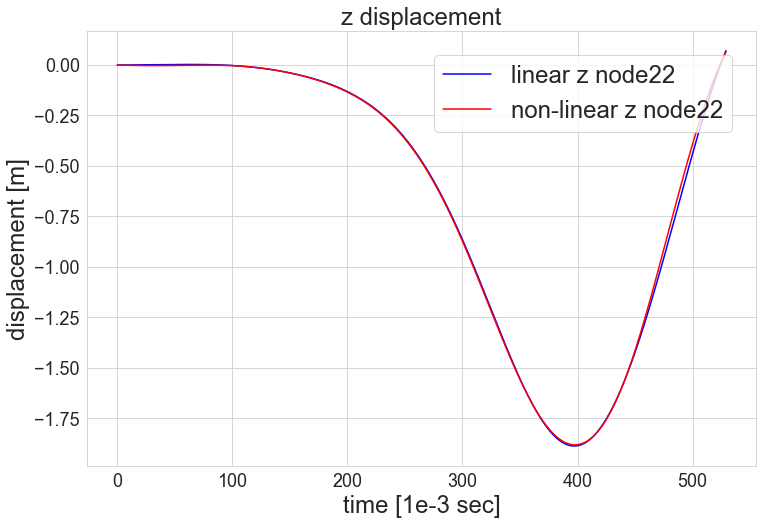

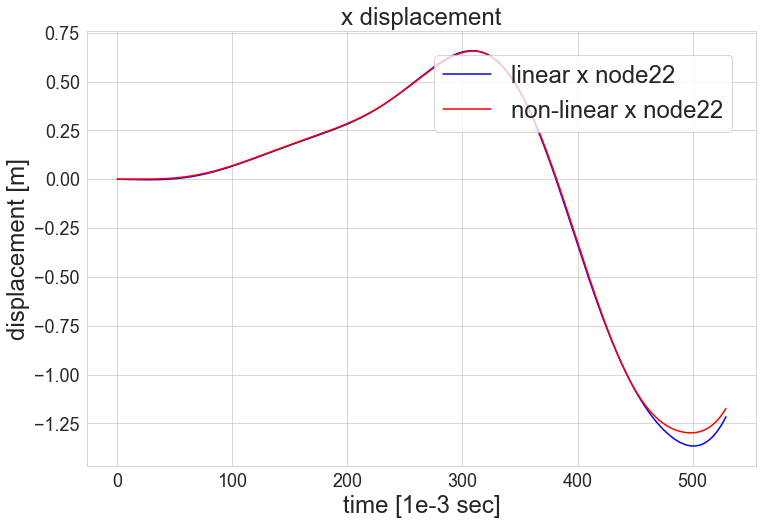

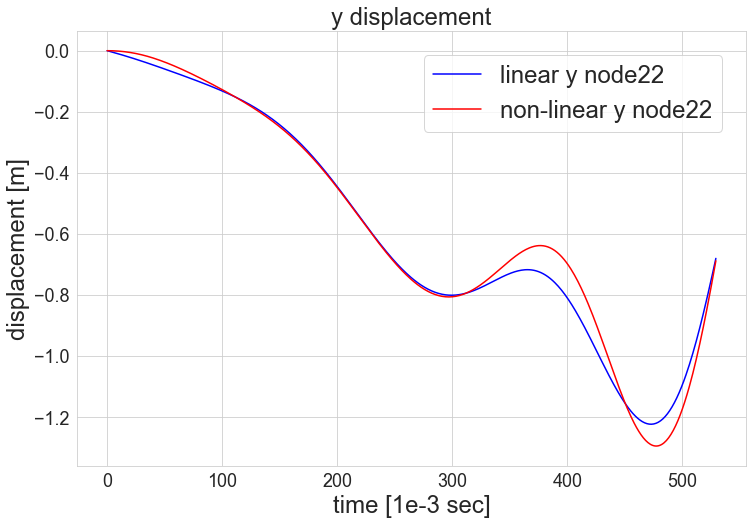

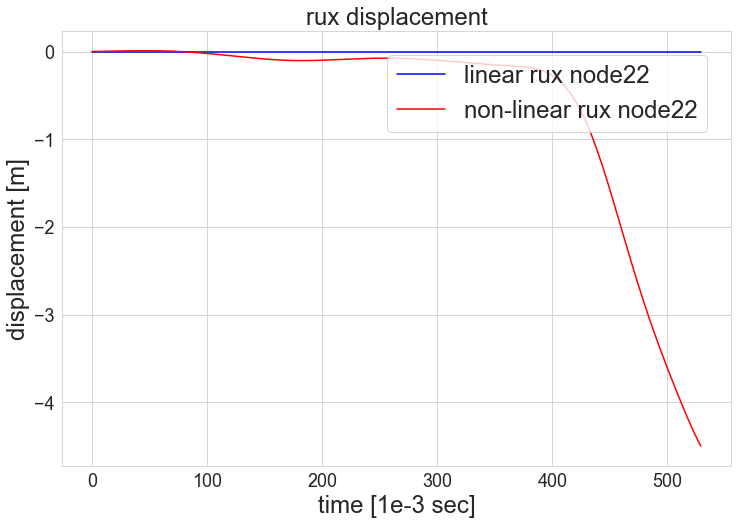

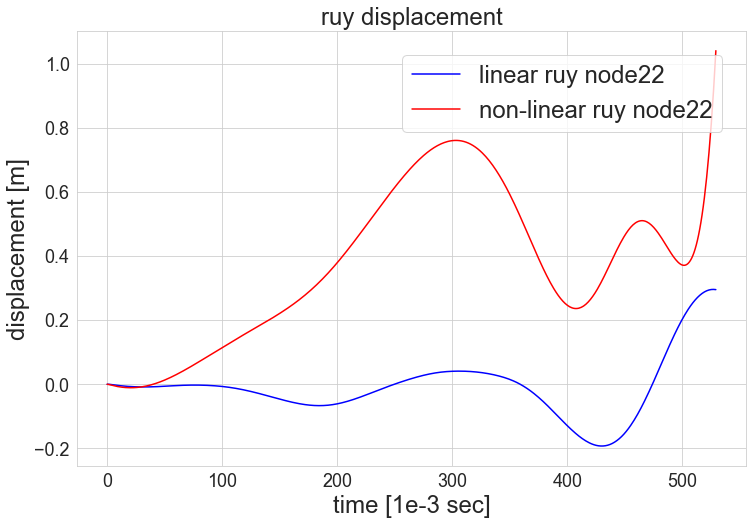

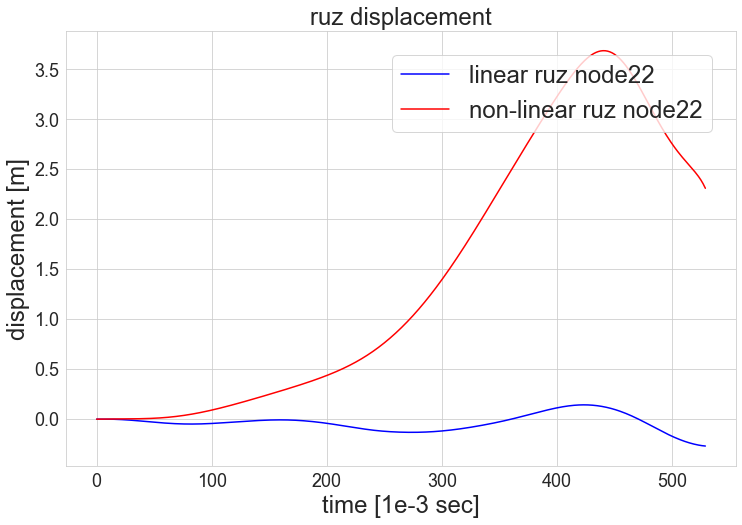

In [55]:
plot_compare_abaqus_dis(abaqus_dis2, disG2, [23], True, '3d-dis-2')

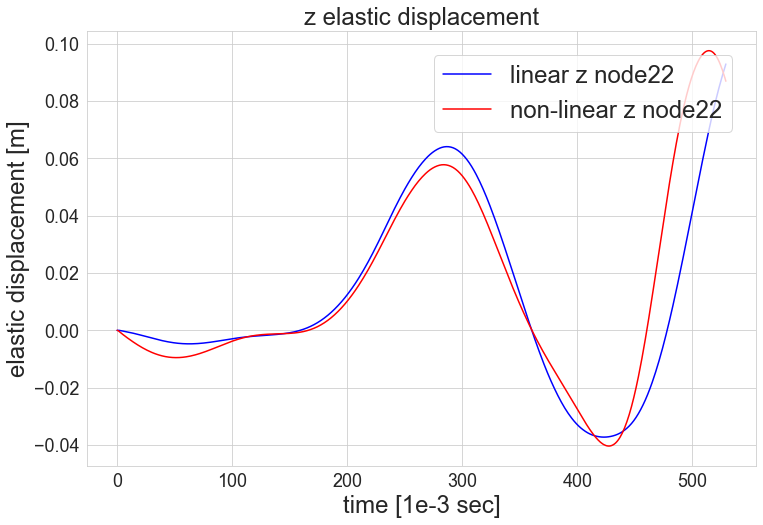

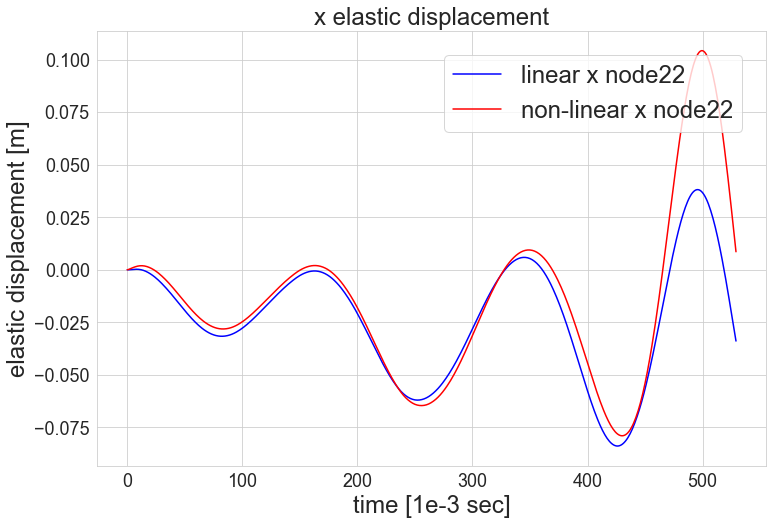

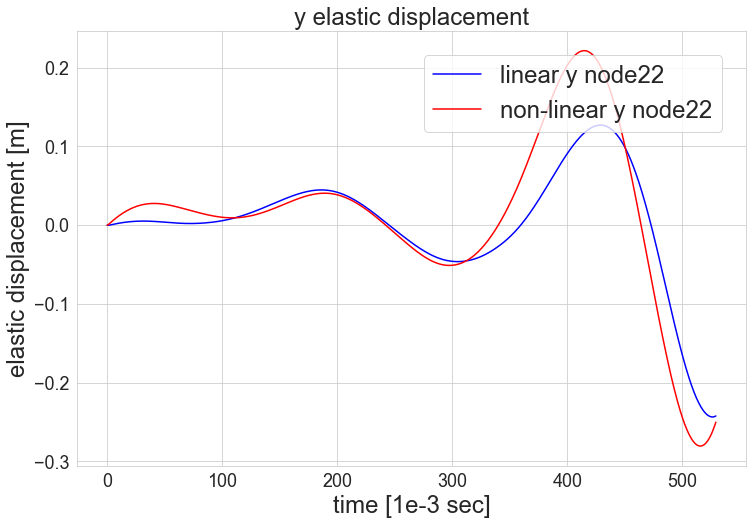

In [56]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis2, coordsG_e_dis2, [23], True, '3d-edis-2')

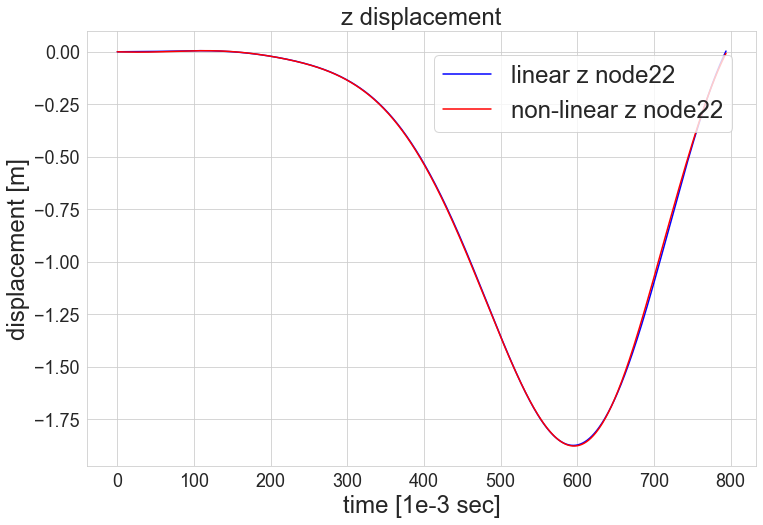

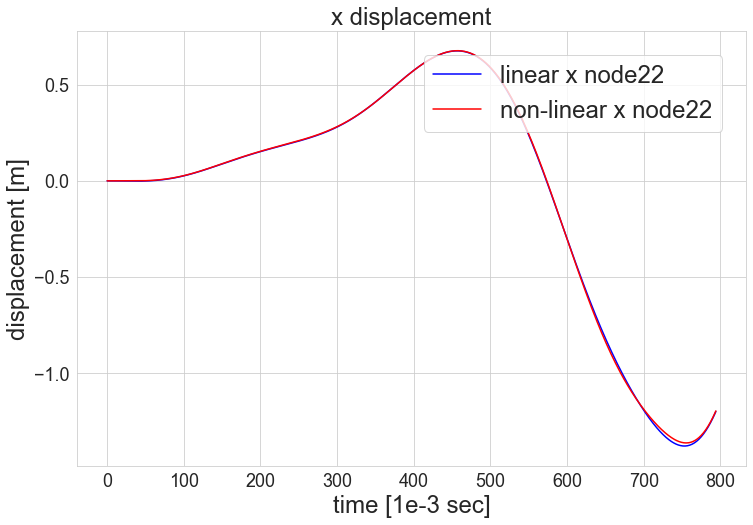

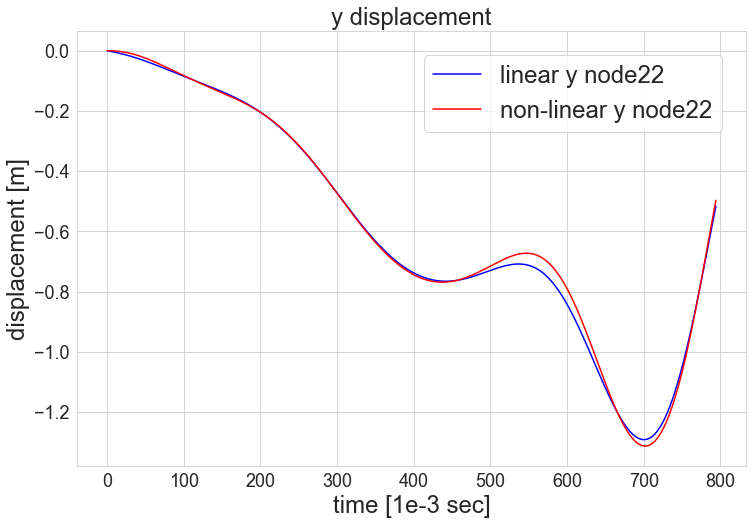

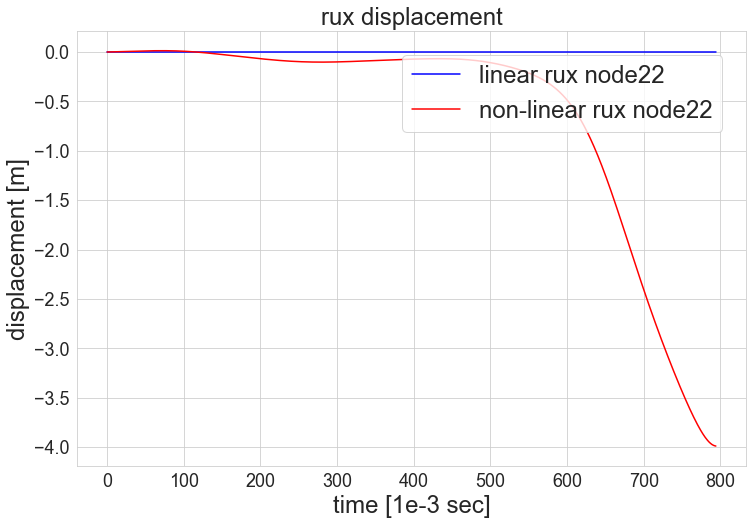

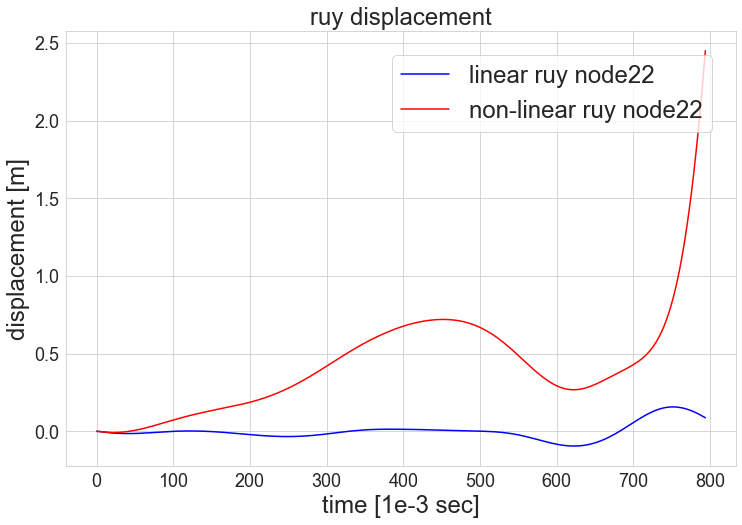

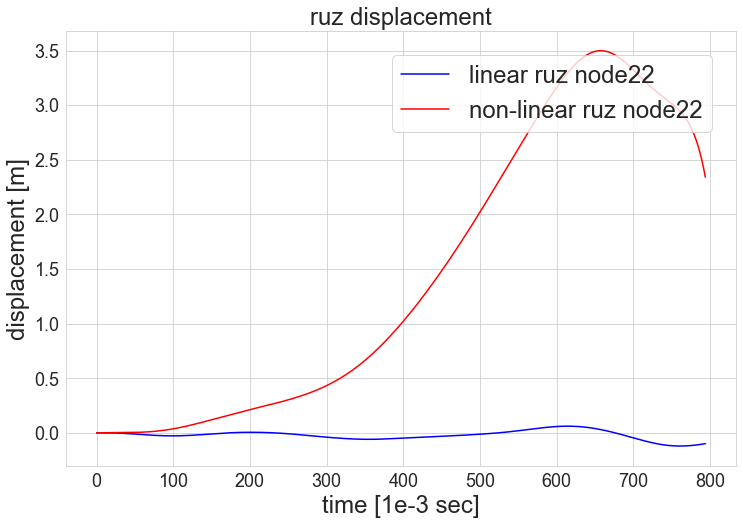

In [57]:
plot_compare_abaqus_dis(abaqus_dis3, disG3, [23], True, '3d-dis-3')

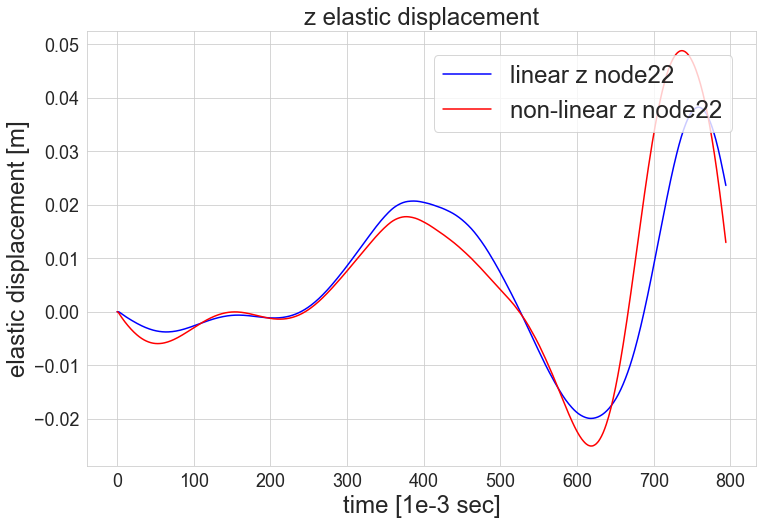

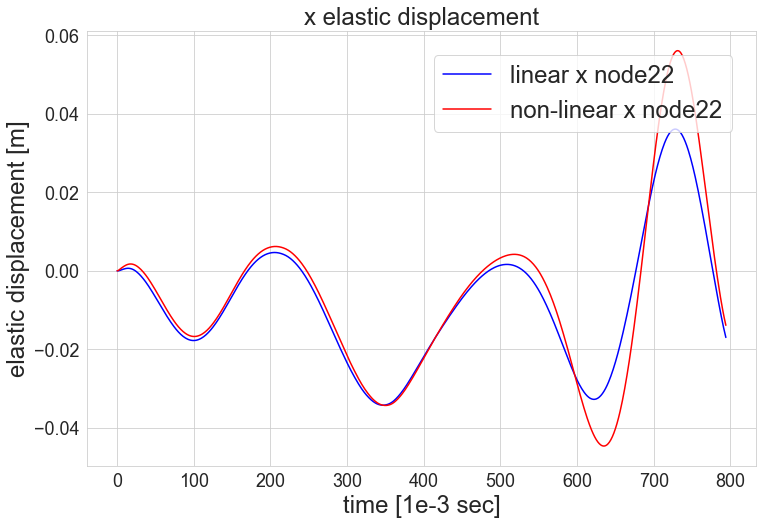

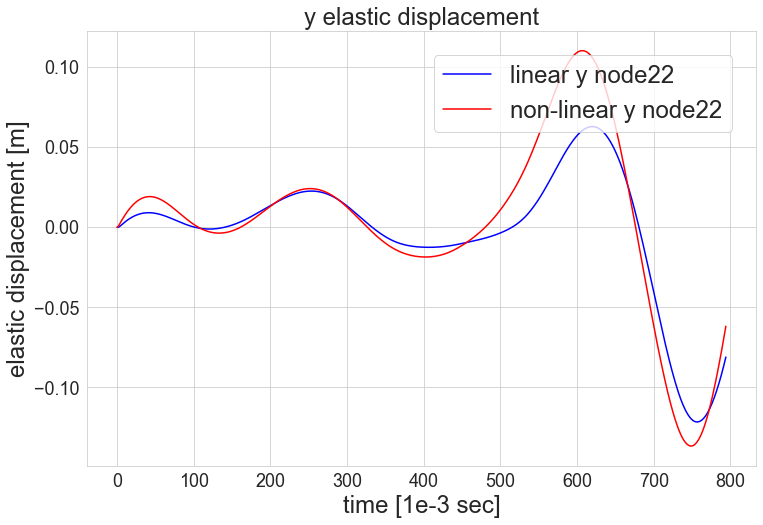

In [58]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis3, coordsG_e_dis3, [23], True, '3d-edis-3')

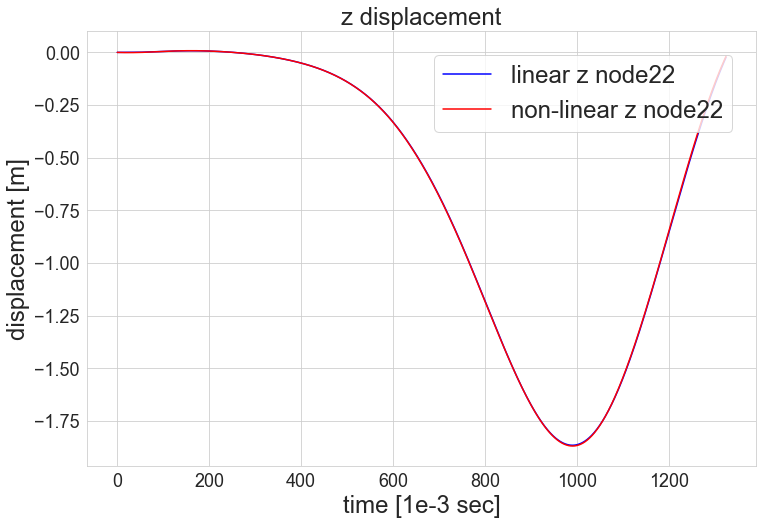

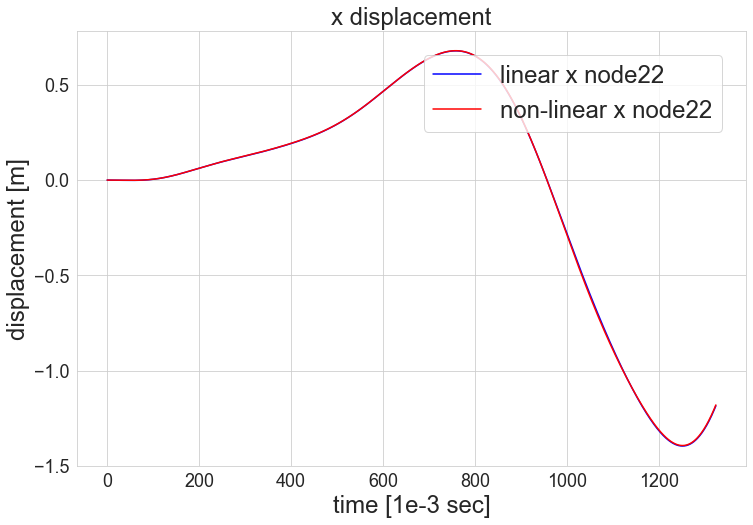

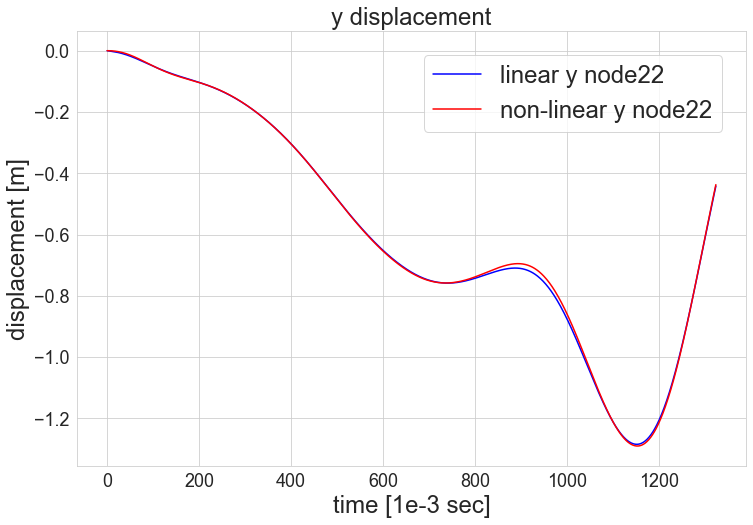

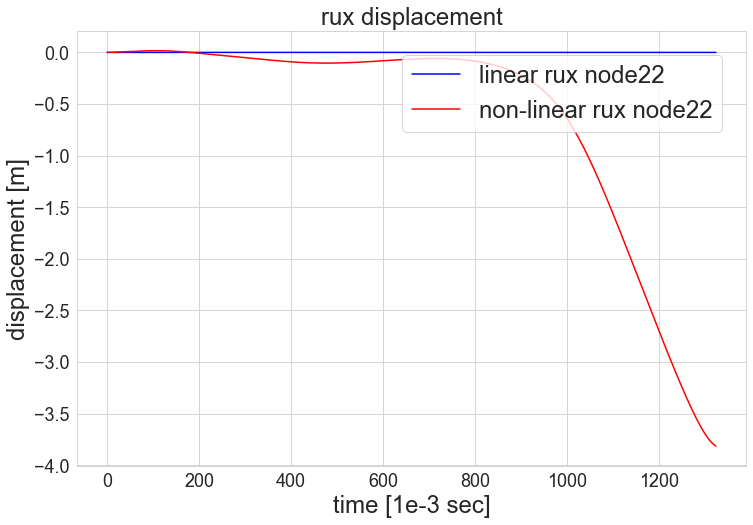

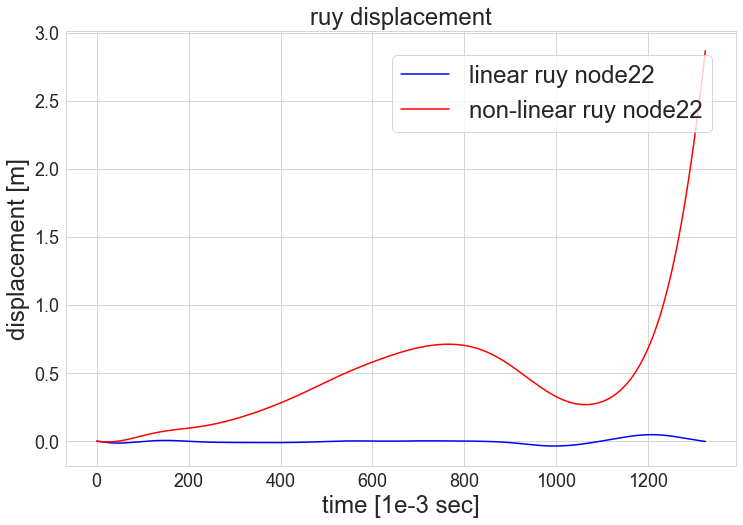

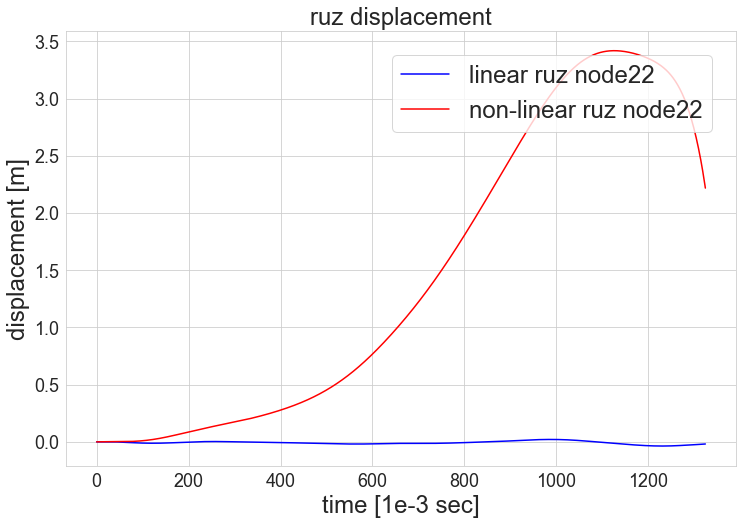

In [59]:
plot_compare_abaqus_dis(abaqus_dis5, disG5, [23], True, '3d-dis-5')

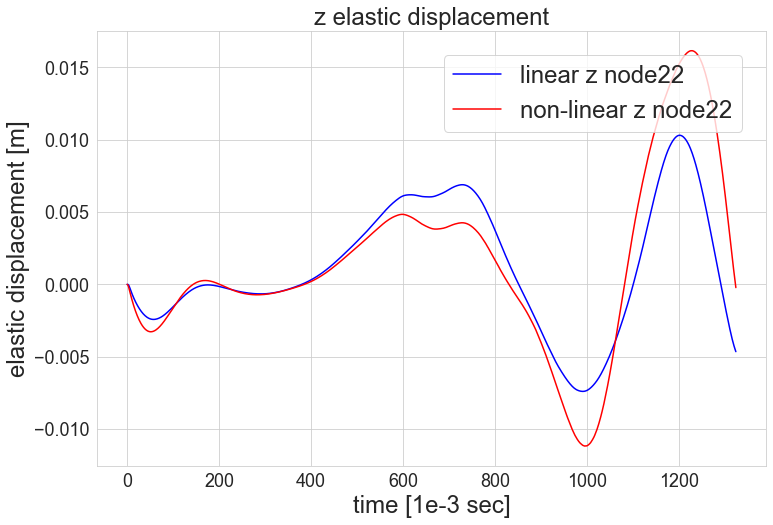

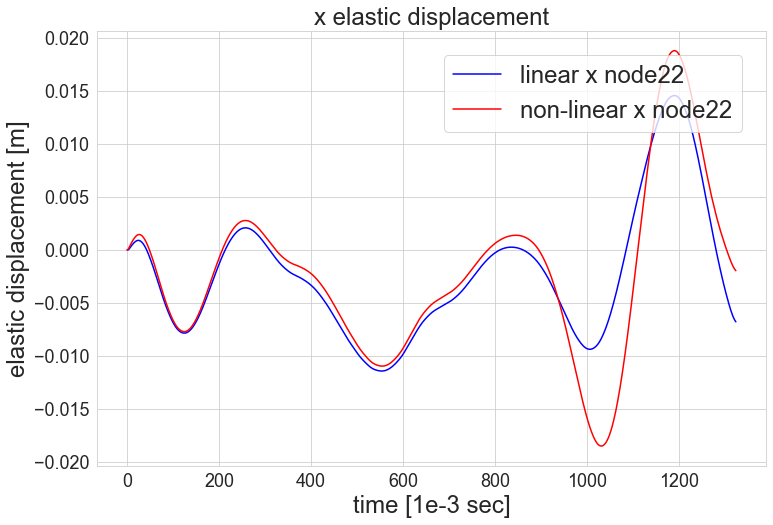

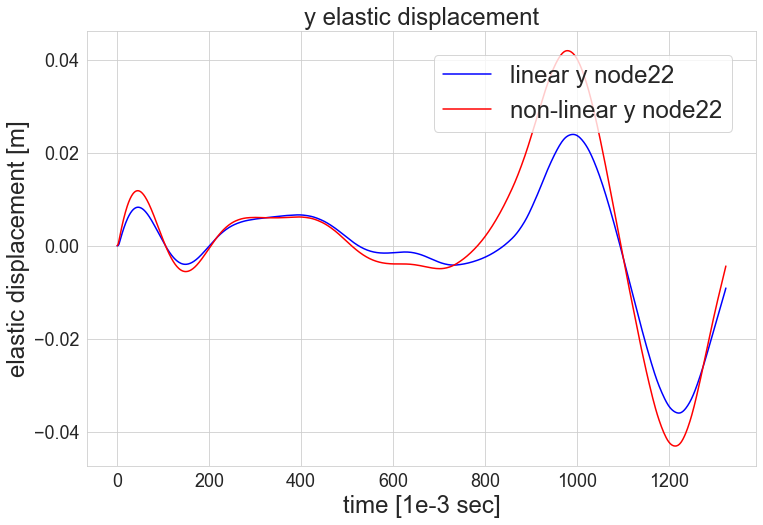

In [60]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis5, coordsG_e_dis5, [23], True, '3d-edis-5')

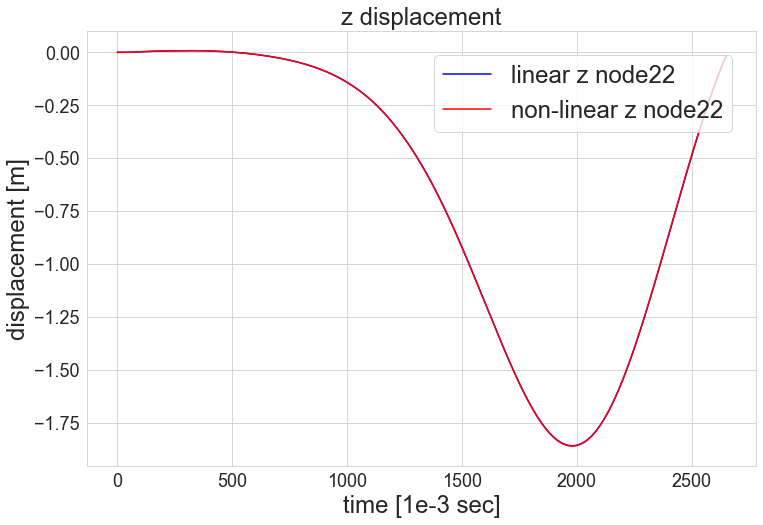

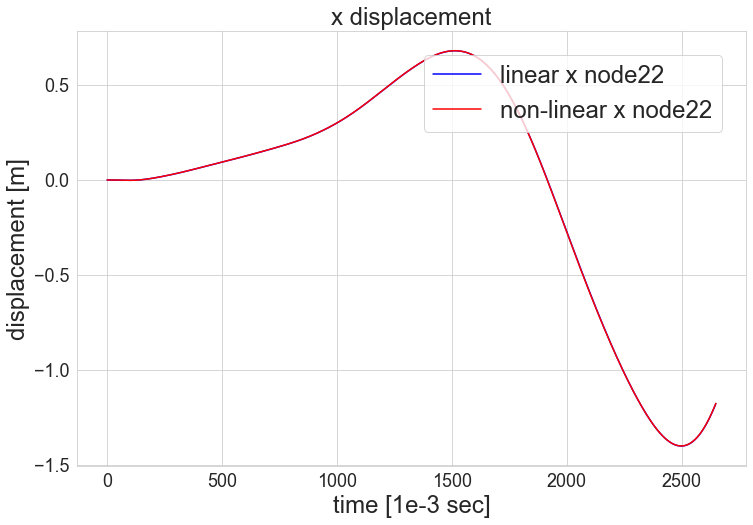

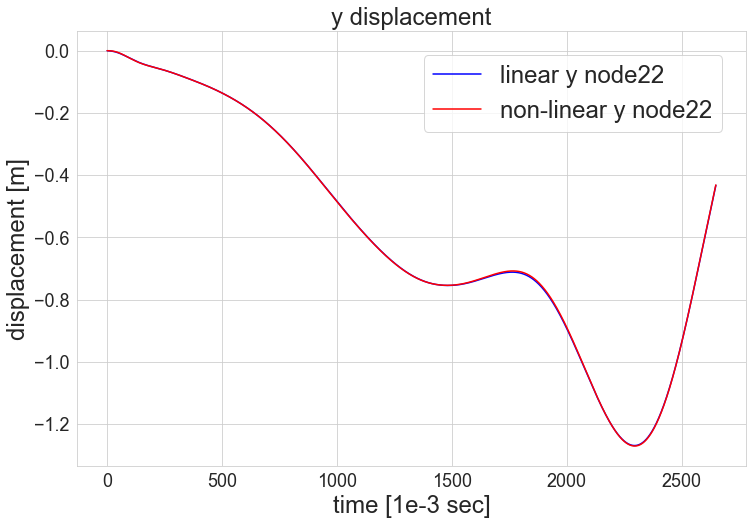

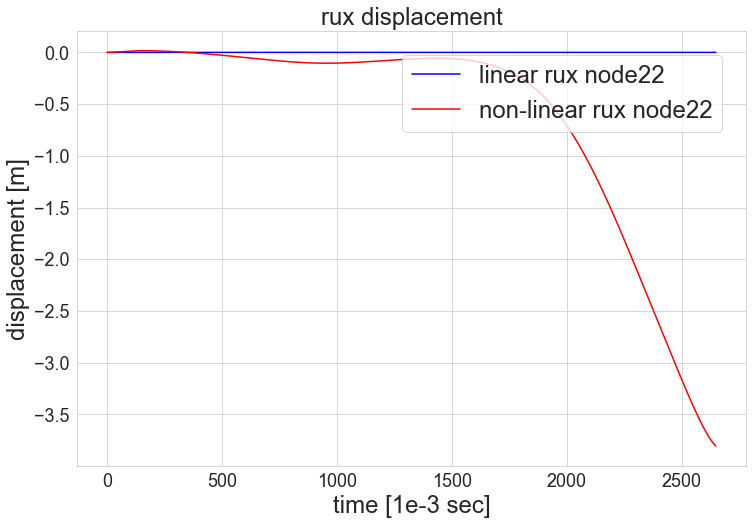

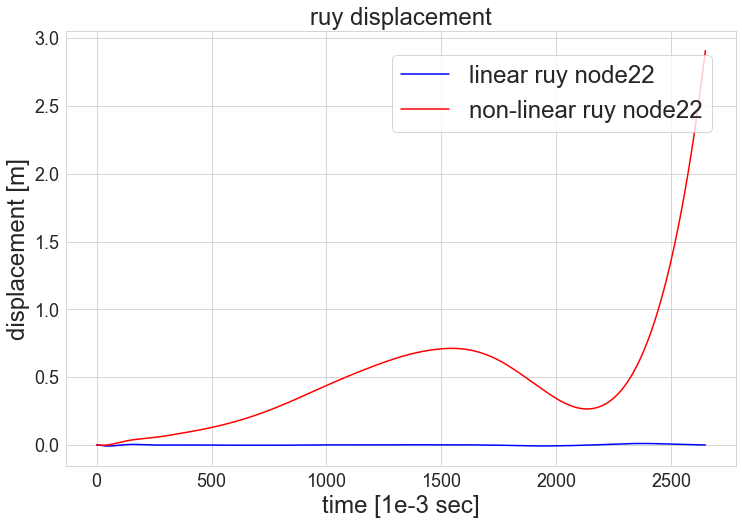

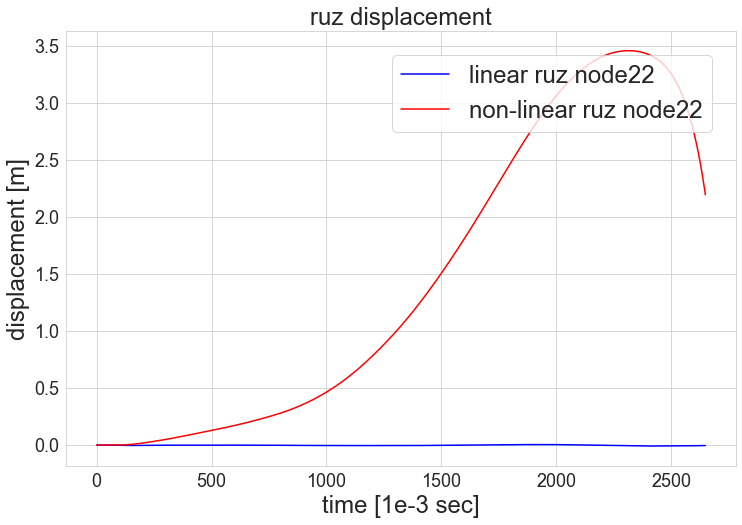

In [61]:
plot_compare_abaqus_dis(abaqus_dis10, disG10, [23], True, '3d-dis-10')

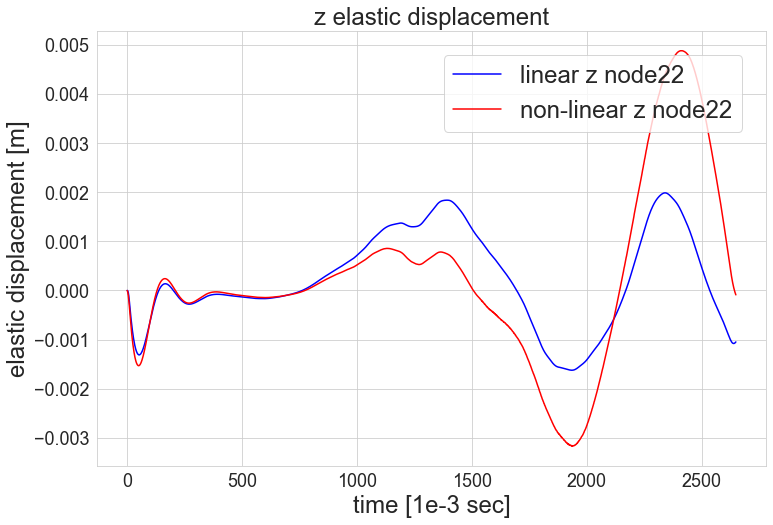

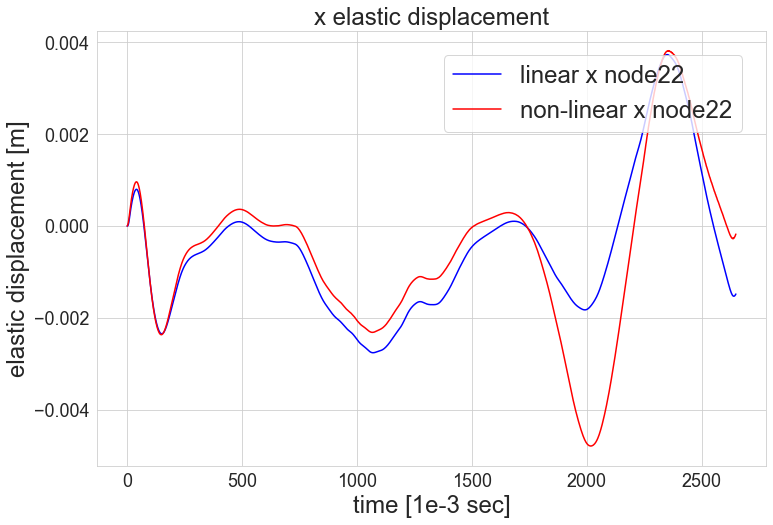

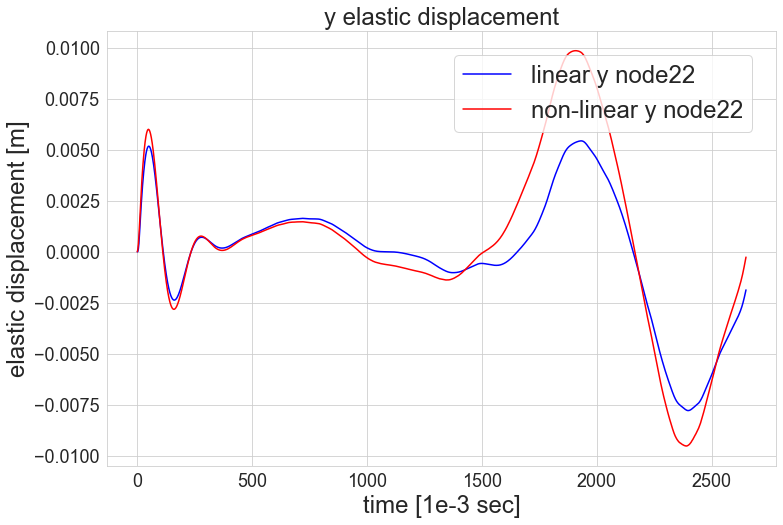

In [62]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis10, coordsG_e_dis10, [23], True, '3d-edis-10')

In [39]:
left = ['1/10', '1/5', '1/3', '1/2', '1']
x_max_h = [3.2212e-3, 1.146e-2, 2.0921e-2, 7.0671e-2, 7.8112e-2]
x_ave_h = [6.4657e-4, 1.9992e-3, 4.0647e-3, 1.0088e-2, 2.1877e-2]
y_max_h = [4.7058e-3, 1.9526e-2, 5.4162e-2, 1.1524e-1, 3.9297e-1]
y_ave_h = [1.1036e-3, 4.3486e-3, 1.2398e-2, 3.0004e-2, 8.7304e-2]
z_max_h = [3.6516e-3, 9.6581e-3, 2.5412e-2, 5.3182e-2, 5.3271e-2]
z_ave_h = [8.6348e-4, 2.0075e-3, 4.1189e-3, 8.1978e-3, 1.8588e-2]

In [46]:
def plot_bar(left, height, axis,save=False,
                            option='average'):         
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(left, height, align='center')          
    plt.title('{0} elastic displacement diff'.format(axis), fontsize=24)
    plt.xlabel('speed', fontsize=24)
    plt.ylabel('elastic displacement diff', fontsize=24)
    plt.tick_params(labelsize=18)
    if save:
        plt.savefig('{0}_{1}.png'.format(axis, option))
    plt.show()

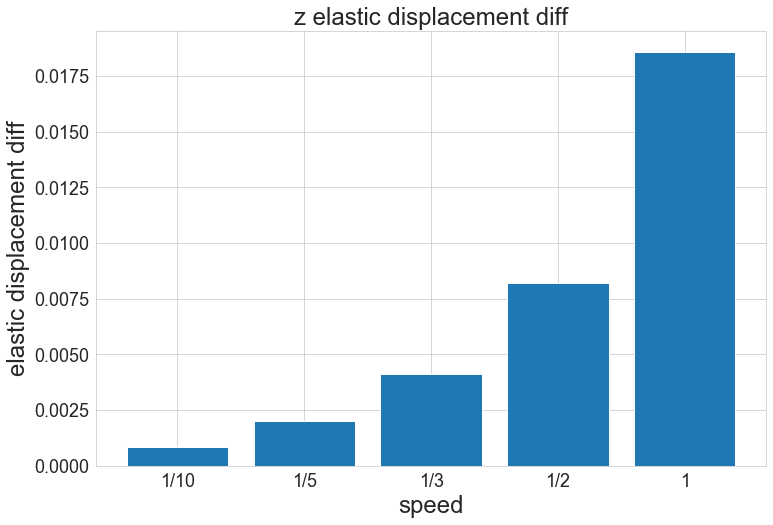

In [49]:
plot_bar(left, z_ave_h, 'z', True)